# Chapter 3: Splitting datasets one feature at a time: decision tree

The decision tree is one of the most commonly used classification techniques. 

It has `decision blocks` (rectangles) and `terminating blocks` (ovals) where some conclusion has been reached, as shown in the following example. The right and left arrows coming out of the decision blocks are known as `branches`, and they can lead to other `decision blocks` or to a `terminating block`.

The *kNN* algorithm did a great job of classifying, but it didn’t lead to any major insights about the data. One of the best things about decision trees is that **humans can easily understand the data**. 
 
The algorithm we’ll build in this chapter will be able to take a set of data, build a decision tree, and draw a tree like the one in the following example. The decision tree does a great job of distilling data into knowledge. With this, we can take a set of unfamiliar data and extract a set of rules. 

The machine learning will take place as the machine creates these rules from the dataset. Decision trees are often used in **expert systems**, and the results obtained by using them are often comparable to those from a human expert with decades of experience in a given field. 

In [11]:
# check directory
# import os
# os.listdir()

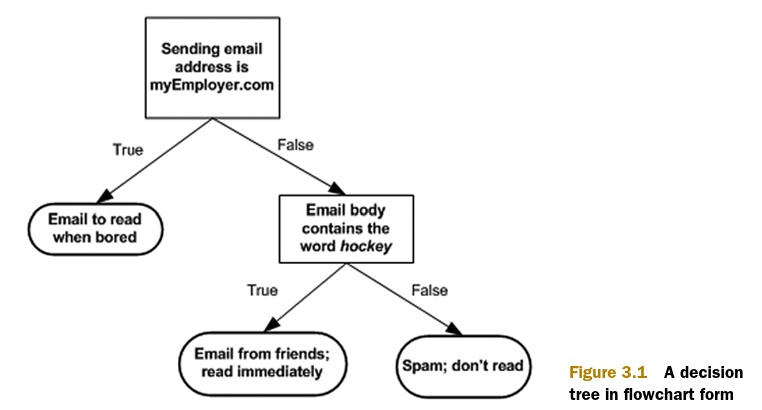

In [12]:
from IPython.display import Image
Image('Machine_Learning_In_Action/Decision_Tree_Example.png')

# Image from: Harrington, P. (2012). Machine Learning In Action. Manning Publications.

In the first section, we’ll discuss methods used to construct trees and start writing code to construct a tree.

Next, we’ll address some metrics that we can use to measure the algorithm’s success.

Finally, we’ll use recursion to build our classifier and plot it using `Matplotlib`. 

When we have the classifier working, we’ll take some data of a contact lens prescription and use our classifier to try to predict what lenses people will need.

### 3.1 Tree construction

Decision trees
* Pros: Computationally cheap to use, easy for humans to understand learned results, missing values OK, can deal with irrelevant features
* Cons: Prone to overfitting
* Works with: Numeric values, nominal value

the decision tree–building algorithm:
* We’ll first discuss the mathematics that decide how to split a dataset using something called `information theory`
* We’ll then write some code to apply this theory to our dataset
* Finally we’ll write some code to build a tree

Steps to build a tree:
* Step 1:  try every feature and measure which split will give out the best results
* Step 2: choose a feature to use to split the data
* Step 3: split the dataset into subsets using the feature. 
* Step 4: repeat the above process until all data is classified (If the data on the branches is the same class, then we've properly classified it and don’t need to continue splitting it. If the data isn’t the same, then we need to repeat the splitting process on this subset.)

**Pseudo-code** for a function called `createBranch()` would look like this:
Check if every item in the dataset is in the same class:
    If so return the class label
    Else 
        find the best feature to split the data
        split the dataset 
        create a branch node
            for each split
                call `createBranch` and add the result to the branch node
        return branch node

Please note the **recursive** nature of `createBranch()`.

**General approach** to decision trees
 1. Collect: Any method.
 2. Prepare: This tree-building algorithm works only on nominal values, so any continuous values will need to be quantized.
 3. Analyze: Any method. You should **visually** inspect the tree after it is built.
 4. Train: Construct a tree data structure. 
 5. Test: Calculate the **error rate** with the learned tree.
 6. Use: This can be used in any supervised learning task. Often, trees are used to better understand the data.
 
**Note**:
We’ll follow the *ID3 algorithm*, which tells us how to split the data and when to stop splitting it. (See http://en.wikipedia.org/wiki/ID3_algorithm for more information.) 

We’re also going to split on one and only one feature at a time. 

Now let's see how to choose which one to use first. 

### 3.1.1 Information gain

We choose to split our dataset in a way that makes our unorganized data more organized. There are multiple ways to do this, and each has its own advantages and disadvantages. One way to organize this messiness is to **measure the information**.

Using information theory, we can measure the information before and after the split. 

Information theory is a branch of science that’s concerned with quantifying information. 

The change in information before and after the split is known as the **information gain**. After knowing how to calculate the information gain, we can split the data across every feature to see which split gives us the highest information gain. The split with the highest information gain is our best option. 

Before we can measure the best split and start splitting our data, we need to know how to calculate the information gain. 

The measure of information of a set is known as the **Shannon entropy**, or just **entropy** for short. Its name comes from the father of information theory, Claude Shannon.
 
**Entropy** is defined as the expected value of the information. First, we need to define information. 

If we’re classifying something that can take on multiple values, the information for symbol $x^{i}$ is defined as

$I(x_{i}) = \log_{2} p(x_{i})$

where $p(x_{i})$ is the probability of choosing this class.

To calculate entropy, we need the expected value of all the information of all possible values of our class. This is given by 

$H = - \sum \limits_{i = 1}^{n} p(x_{i}) \log_{2} p(x_{i})$

where $n$ is the number of classes. 

In [13]:
# define a function to calculate the Shannon entropy of a dataset
from math import log

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    # create a dictionary whose keys are the labels in the dataset
    labelCounts = {}
    for featVec in dataSet:                        
        currentLabel = featVec[-1]                      
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0              
        labelCounts[currentLabel] += 1             
    # calculate the Shannon entropy
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2)             
    return shannonEnt

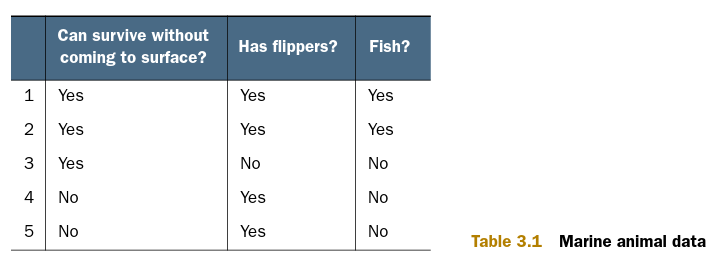

In [14]:
# create a dataset that matches the following table
Image('Machine_Learning_In_Action/Marine_animal_data.png')

In [15]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels

In [16]:
myDat, labels = createDataSet()

In [17]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [18]:
labels

['no surfacing', 'flippers']

In [19]:
# calculate the Shannon entropy
calcShannonEnt(myDat)

0.9709505944546686

The higher the entropy, the more *mixed up* the data is. 

Let’s make the data a little messier and see how the entropy changes. 

We’ll add a third class, which is called `maybe`, and see how the entropy changes: 

In [20]:
myDat[0][-1] = 'maybe'

In [21]:
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [22]:
calcShannonEnt(myDat)

1.3709505944546687

Let’s split the dataset in a way that will give us the largest information gain. We won’t know how to do that unless we actually split the dataset and measure the information gain.

Another common measure of disorder in a set is the **Gini impurity**, which is the probability of choosing an item from the set and the probability of that item being misclassified. 

We won’t get into the Gini impurity. Instead, we’ll move on to splitting the dataset and building the tree. 

### 3.1.2 Splitting the dataset

For our classifier algorithm to work, we need to measure the entropy, split the dataset, measure the entropy on the split sets, and see if splitting it was the right thing to do. We’ll do this for all of our features to determine the best feature to split on.

In [23]:
# create a function to split the dataset
def splitDataSet(dataSet, axis, value):
    retDataSet = []                          
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]        
            reducedFeatVec.extend(featVec[axis+1:])       
            retDataSet.append(reducedFeatVec)      
    return retDataSet

In [24]:
# difference between append() and extend()
a = [1, 2, 3]
b = [4, 5, 6]

a.extend(b)

In [25]:
a

[1, 2, 3, 4, 5, 6]

In [26]:
a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)

a

[1, 2, 3, [4, 5, 6]]

In [27]:
# try one example
myDat,labels = createDataSet()

In [28]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [29]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [30]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]